In [2]:
#***********************************************************************************************************************************************
#                                                                                                                                              *
#                                                 Deep Learning for the Gaussian Wiretap Channel                                               *
#                              This code implements a communication system that utilizes autoencoder models for secure communication.          *
#          The system includes an encoder, Bob's decoder, and Eve's decoder that are trained to communicate securely over a noisy channel.     *
#                                                                                                                                              *
#   Here is a brief explanation of the code:                                                                                                   *
#                                                                                                                                              *
# - The code first sets up the necessary libraries, constants, and definitions for the neural network models.                                  *
# - It defines utility functions, layers, and models for the encoder and decoders.                                                             *
# - It includes training methods for training Bob and Eve's decoders, as well as for the security training phase using k-means clustering.     *
# - Evaluation functions to calculate Bit Error Rates for different Signal-to-Noise Ratios (SNR) are included.                                 *
# - The code also includes functions for testing and visualization, such as plotting loss and encoding patterns.                               *
# - It tests the autoencoder models with normal data, then creates a secure encoding using k-means clustering.                                 *
#   for the security procedure and tests the secure communication.                                                                             *
# - the results are visualized in a plot showing the Symbol Error Rate versus SNR for Bob and Eve in both the traditional and secure setups.   *
#                                                                                                                                              *
#***********************************************************************************************************************************************

In [3]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
from scipy import special
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from EqualGroupsKMeans import EqualGroupsKMeans


# Initialize random seeds AND Define Constants
np.random.seed(42)
tf.random.set_seed(42)
M = 16
n = 16
k = int(np.log2(M))
M_sec = 4
SAMPLE_SIZE = 50000
TRAINING_SNR = 10
messages = np.random.randint(M, size=SAMPLE_SIZE)                                                               # Generate random messages
one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[range(M)])                                     # Encode messages using OneHotEncoder
data_oneH = one_hot_encoder.fit_transform(messages.reshape(-1, 1))

In [4]:
class CustomFunctions:
    @staticmethod
    def snr_to_noise(snrdb):                                                                                    # Convert SNR in dB to noise standard deviation
        snr = 10**(snrdb/10)
        noise_std = 1/np.sqrt(2*snr)
        return noise_std

    @staticmethod
    def B_Ber(input_msg, msg):                                                                                  # Calculate bit error rate from input and predicted messages
        pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
        bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
        return bber

    @staticmethod
    def random_batch(X, batch_size=32):                                                                         # Get a random batch of data from X
        idx = np.random.randint(len(X), size=batch_size)
        return X[idx]

In [5]:
noise_std = CustomFunctions.snr_to_noise(TRAINING_SNR)                                                          # Convert SNR to noise standard deviation for training data
noise_std_eve = CustomFunctions.snr_to_noise(7)                                                                 # Convert SNR to noise standard deviation for Eve channel

class CustomLayers:
    norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x)))))                                 # Normalize layer
    shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2, n]))                                                      # Reshape layer for 3D input tensor
    shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2*n]))                                                      # Reshape layer for 2D input tensor
    channel_layer = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))               # adding noise according
    channel_layer_eve = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std_eve)))       # adding noise according

In [6]:
class Models:
    # Encoder model architecture
    encoder = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=[M]),                                                               # Input layer
        keras.layers.Dense(M, activation="elu"),                                                                # Dense layer with ELU activation
        keras.layers.Dense(2*n, activation=None),                                                               # Dense layer without activation
        CustomLayers.shape_layer,                                                                               # Reshape layer
        CustomLayers.norm_layer                                                                                 # Normalize layer
    ])
    # Decoder model architecture for Bob
    decoder_bob = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=[2, n]),                                                            # Input layer with 3D input tensor
        CustomLayers.shape_layer2,                                                                              # Reshape layer for 2D input tensor
        keras.layers.Dense(M, activation="elu"),                                                                # Dense layer with ELU activation
        keras.layers.Dense(M, activation="softmax")                                                             # Dense layer with softmax activation
    ])
    # Decoder model architecture for Eve
    decoder_eve = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=[2, n]),                                                            # Input layer with 3D input tensor
        CustomLayers.shape_layer2,                                                                              # Reshape layer for 2D input tensor
        keras.layers.Dense(M, activation="elu"),                                                                # Dense layer with ELU activation
        keras.layers.Dense(M, activation="softmax")                                                             # Dense layer with softmax activation
    ])

In [7]:
class Training:
    @staticmethod
    def train_Bob(n_epochs=5, n_steps=20, plot_encoding=True, only_decoder=False):
        for epoch in range(1, n_epochs + 1):                                                                    # Loop over epochs
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))                                        # Print epoch progress
            for step in range(1, n_steps + 1):                                                                  # Loop over steps
                X_batch  = CustomFunctions.random_batch(data_oneH, batch_size)                                  # Get random batch
                with tf.GradientTape() as tape:                                                                 # Record gradients
                    y_pred = autoencoder_bob(X_batch, training=True)                                            # Predict
                    main_loss = tf.reduce_mean(loss_fn(X_batch, y_pred))                                        # Calculate loss
                    loss = main_loss                                                                            # Assign loss
                if only_decoder:                                                                                # If training only decoder
                    gradients = tape.gradient(loss, Models.decoder_bob.trainable_variables)                     # Calculate gradients
                    optimizer.apply_gradients(zip(gradients, Models.decoder_bob.trainable_variables))           # Apply gradients to decoder
                else:                                                                                           # If training full autoencoder
                    gradients = tape.gradient(loss, autoencoder_bob.trainable_variables)                        # Calculate gradients
                    optimizer.apply_gradients(zip(gradients, autoencoder_bob.trainable_variables))              # Apply gradients to autoencoder
                mean_loss(loss)                                                                                 # Track mean loss
                plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)                               # Plot loss
            plot_batch_loss(epoch, mean_loss, X_batch, y_pred)                                                  # Plot batch loss
#*********************************************************************************************************************************************************************
    @staticmethod
    def train_Eve(n_epochs=5, iterations=20, plot_encoding=True):
        for epoch in range(1, n_epochs + 1):                                                                    # Loop through each epoch
            print("Training Eve in Epoch {}/{}".format(epoch, n_epochs))                                        # Display current epoch
            for step in range(1, n_steps + 1):                                                                  # Loop through each step within the epoch
                X_batch  = CustomFunctions.random_batch(data_oneH, batch_size)                                  # Get a random batch of data
                with tf.GradientTape() as tape:                                                                 # Record operations for automatic differentiation
                    y_pred = autoencoder_eve(X_batch, training=True)                                            # Forward pass through autoencoder
                    main_loss = tf.reduce_mean(loss_fn(X_batch, y_pred))                                        # Calculate main loss
                    loss = main_loss                                                                            # Total loss is the main loss
                gradients = tape.gradient(loss, Models.decoder_eve.trainable_variables)                         # Compute gradients
                optimizer.apply_gradients(zip(gradients, Models.decoder_eve.trainable_variables))               # Update model parameters using optimizer
                mean_loss(loss)                                                                                 # Compute mean loss
                plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)                               # Plot loss and encoding (if specified)
            plot_batch_loss(epoch, mean_loss, X_batch, y_pred)                                                  # Plot batch loss for the epoch
#*********************************************************************************************************************************************************************
    @staticmethod
    def init_kmeans(symM=16, satellites=4, n=100):
        '''Initializes equal sized clusters with the whole message set'''
        inp = np.eye(symM, dtype=int)                                                                           # Generate one-hot encoded input vectors
        unit_codewords = Models.encoder.predict(inp)                                                            # Get unit codewords using the encoder model
        kmeans = EqualGroupsKMeans(n_clusters=satellites)                                                       # Apply k-means clustering
        kmeans.fit(unit_codewords.reshape(symM,2*n))
        return kmeans
#*********************************************************************************************************************************************************************
    @staticmethod
    def generate_mat(kmeans_labels, satellites=4, symM=16):
        '''Generates the matrix for equalizing the input distribution on Eve's side'''
        gen_matrix = np.zeros((symM, symM))                                                                     # Initialize the generation matrix
        for j in range(satellites):                                                                             # Iterate over each cluster
            for i in range(symM):                                                                               # Iterate over each symbol
                if kmeans_labels[i] == j:                                                                       # Check if the symbol belongs to the current cluster
                    for k in range(symM):                                                                       # Adjust the matrix for equalization
                        if kmeans_labels[k] == j:
                            gen_matrix[i, k] = 1 / satellites
        gen_mat = tf.cast(gen_matrix, tf.float64)                                                               # Convert the matrix to float64 datatype
        return gen_mat
#*********************************************************************************************************************************************************************
    @staticmethod
    def train_Secure(kmeans_labels, n_epochs=5, iterations=20, alpha=0.7, plot_encoding=True):
        generator_matrix = Training.generate_mat(kmeans_labels, M_sec, M)                                       # Generate transformation matrix based on KMeans labels
        for epoch in range(1, n_epochs + 1):                                                                    # Iterate over epochs
            print("Training for Security in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, iterations + 1):                                                               # Iterate over steps
                X_batch  = CustomFunctions.random_batch(data_oneH, batch_size)                                  # Generate random batch of data
                x_batch_s= tf.matmul(X_batch, generator_matrix)                                                 # Transform input batch
                with tf.GradientTape() as tape:                                                                 # Calculate predictions for Bob and Eve
                    y_pred_bob = autoencoder_bob(X_batch, training=True)
                    y_pred_eve = autoencoder_eve(X_batch, training=False)
                    loss_bob = tf.reduce_mean(loss_fn(X_batch, y_pred_bob))                                     # Calculate losses for Bob and Eve
                    loss_eve = tf.reduce_mean(loss_fn(x_batch_s, y_pred_eve))
                    loss_sec =  (1-alpha)*loss_bob + alpha*loss_eve                                             # Combine losses to form security loss
                gradients = tape.gradient(loss_sec, autoencoder_bob.trainable_variables)                        # Calculate gradients and apply to update Bob's autoencoder
                optimizer.apply_gradients(zip(gradients, autoencoder_bob.trainable_variables))
                mean_loss(loss_sec)                                                                             # Update mean loss and plot loss
                plot_loss(step, epoch, mean_loss, X_batch, y_pred_bob, plot_encoding)
            plot_batch_loss(epoch, mean_loss, X_batch, y_pred_bob)                                              # Plot batch loss for each epoch

In [8]:
class Evaluation:
    @staticmethod
    def Test_AE(data):
        '''Calculate Bit Error for varying SNRs'''
        snr_range = np.linspace(0, 15, 30)                                                                      # SNR range from 0 to 15 with 30 points
        bber_vec_bob = [None] * len(snr_range)                                                                  # Initializing a list for Bob's Bit Error Rate
        bber_vec_eve = [None] * len(snr_range)                                                                  # Initializing a list for Eve's Bit Error Rate
        for db in range(len(snr_range)):
            noise_std = CustomFunctions.snr_to_noise(snr_range[db])                                             # Calculate noise standard deviation
            noise_std_eve = CustomFunctions.snr_to_noise(7)                                                     # Eve's noise standard deviation
            code_word = Models.encoder.predict(data)                                                            # Get the encoded data
            rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)           # Add noise
            rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(rcvd_word), mean=0.0, stddev=noise_std_eve)   # Add Eve's noise
            dcoded_msg_bob = Models.decoder_bob.predict(rcvd_word)                                              # Decode Bob's received data
            dcoded_msg_eve = Models.decoder_eve.predict(rcvd_word_eve)                                          # Decode Eve's received data
            bber_vec_bob[db] = CustomFunctions.B_Ber(data, dcoded_msg_bob)                                      # Calculate Bob's Bit Error Rate
            bber_vec_eve[db] = CustomFunctions.B_Ber(data, dcoded_msg_eve)                                      # Calculate Eve's Bit Error Rate
            print(f'Progress: {db + 1} of {30} parts')                                                          # Display progress
        return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)                                             # Return Bob's and Eve's Bit Error Rates for each SNR
#*********************************************************************************************************************************************************************
    @staticmethod
    def satellite_labels(kmeans_labels, data_label, sats=4, data_size=150000):
            code_mat = np.zeros((sats, M_sec))                                                                  # Initialize the code matrix with the specified dimensions
            n = np.zeros(sats, dtype=np.int32)                                                                  # Initialize a counter for each satellite
            for index in range(M):
                sat = kmeans_labels[index]                                                                      # Get the satellite label for the current index
                if n[sat] < M_sec:                                                                              # Check if satellite has capacity for more data
                    code_mat[sat, n[sat]] = index                                                               # Assign the index to the code matrix for the satellite
                    n[sat] += 1                                                                                 # Increment the counter for the satellite
            coded_label = np.zeros(data_size)                                                                   # Initialize the coded label array
            for i in range(data_size):
                aux_var = data_label[i]                                                                         # Get the current data label
                coded_label[i] = code_mat[np.random.randint(sats), aux_var]                                     # Assign a code based on random satellite and data label
            return coded_label, code_mat                                                                        # Return the coded labels and the code matrix
#*********************************************************************************************************************************************************************
    @staticmethod
    def sec_decoding(code_mat, pred_output, satellites, clusters):
            decoded_data = np.zeros(len(pred_output), dtype=int)                                                # Initialize array for decoded data
            for i, output in enumerate(pred_output):
                found = False                                                                                   # Flag to indicate if the output is found
                for cloud in range(satellites):
                    for msg in range(clusters):
                        if code_mat[cloud, msg] == output:
                            decoded_data[i] = msg                                                               # Decode the message
                            found = True                                                                        # Set found flag to True
                            break
                    if found:
                        break
            return decoded_data                                                                                 # Return the decoded data
#*********************************************************************************************************************************************************************
    @staticmethod
    def Test_secure_AE(coded_data, code_mat, real_data):
        '''Calculate symbol error for various SNRs.'''
        snr_range = np.linspace(0, 15, 30)                                                                      # Define SNR range
        bber_vec_bob = [None] * len(snr_range)                                                                  # Vector for Bob's bit error rate
        bber_vec_eve = [None] * len(snr_range)                                                                  # Vector for Eve's bit error rate
        for db in range(len(snr_range)):                                                                        # Iterate over SNR range
            noise_std = CustomFunctions.snr_to_noise(snr_range[db])
            noise_std_eve = CustomFunctions.snr_to_noise(7)
            code_word = Models.encoder.predict(coded_data)                                                      # Generate received word with noise for Bob
            rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
            rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve)   # Generate received word with noise for Eve
            pred_msg_bob = Models.decoder_bob.predict(rcvd_word)                                                # Predict messages for Bob and Eve
            pred_msg_eve = Models.decoder_eve.predict(rcvd_word_eve)
            decoded_msg_bob = Evaluation.sec_decoding(code_mat, np.array(tf.argmax(pred_msg_bob,1)), M_sec, M_sec)  # Decode messages for Bob and Eve
            decoded_msg_eve = Evaluation.sec_decoding(code_mat, np.array(tf.argmax(pred_msg_eve,1)), M_sec, M_sec)
            bber_vec_bob[db] = np.mean(np.not_equal(decoded_msg_bob, real_data))                                # Calculate bit error rate for Bob and Eve
            bber_vec_eve[db] = np.mean(np.not_equal(decoded_msg_eve, real_data))
            print(f'Progress: {db+1} of {30} parts')
        return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)                                             # Return Bob's and Eve's bit error rates for the SNR range

In [9]:
def test_encoding(M=16, n=1):                                                                                   # Function to test encoding
    inp = np.eye(M, dtype=int)                                                                                  # Generate identity matrix
    coding = Models.encoder.predict(inp)                                                                        # Get encoded representation
    fig = plt.figure(figsize=(4,4))                                                                             # Create figure
    plt.plot(coding[:,0], coding[:, 1], "b.")                                                                   # Plot encoded data points
    plt.xlabel("$x_1$", fontsize=18)                                                                            # Set x-axis label
    plt.ylabel("$x_2$", fontsize=18, rotation=0)                                                                # Set y-axis label
    plt.grid(True)                                                                                              # Show grid
    plt.gca().set_ylim(-2, 2)                                                                                   # Set y-axis limits
    plt.gca().set_xlim(-2, 2)                                                                                   # Set x-axis limits
    plt.show()                                                                                                  # Display plot

def test_noisy_codeword(data):                                                                                  # Function to test noisy codeword
    rcvd_word = data[1:2000]                                                                                    # Extract received word
    fig = plt.figure(figsize=(4,4))                                                                             # Create figure
    plt.plot(rcvd_word[:,0], rcvd_word[:, 1], "b.")                                                             # Plot received word data points
    plt.xlabel("$x_1$", fontsize=18)                                                                            # Set x-axis label
    plt.ylabel("$x_2$", fontsize=18, rotation=0)                                                                # Set y-axis label
    plt.grid(True)                                                                                              # Show grid
    plt.gca().set_ylim(-2, 2)                                                                                   # Set y-axis limits
    plt.gca().set_xlim(-2, 2)                                                                                   # Set x-axis limits
    plt.show()                                                                                                  # Display plot

In [10]:
n_epochs = 5
batch_size = 200
n_steps = len(data_oneH) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.005)
loss_fn = keras.losses.categorical_crossentropy
mean_loss = keras.metrics.Mean()

def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'                                      # Display iteration results every 10 steps
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), CustomFunctions.B_Ber(X_batch, y_pred)))
        if plot_encoding:                                                                                       # Check if encoding plot should be displayed
            test_encoding()

def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
    template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'                       # Display interim results for the epoch
    print(template_outer_loop.format(epoch, mean_loss.result(), CustomFunctions.B_Ber(X_batch, y_pred)))

In [11]:
# test msg sequence for normal encoding
N_test = 150000
test_msg = np.random.randint(M, size=N_test)
one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(M)])
data_oh_normal = one_hot_encoder.fit_transform(test_msg.reshape(-1,1))

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)                                                      # Define and Initialize the optimizer
autoencoder_bob = keras.models.Sequential([Models.encoder, Models.decoder_bob])                                 # Create autoencoder models
autoencoder_eve = keras.models.Sequential([Models.encoder, Models.decoder_eve])
_ = autoencoder_bob(data_oneH[:1])                                                                              # Call models to ensure weights are created
_ = autoencoder_eve(data_oneH[:1])
# Build the optimizer after the models' weights have been created
optimizer.apply_gradients([(tf.zeros_like(var), var) for var in autoencoder_bob.trainable_variables + autoencoder_eve.trainable_variables])

Training.train_Bob(n_epochs, n_steps, False, False)                                                             # Use the built optimizer in the training loops
Training.train_Eve(n_epochs-1, n_steps, False)                                                                  # reduced epochs to match accuracy of both
bber_data_bob, bber_data_eve = Evaluation.Test_AE(data_oh_normal)                                               # Test the autoencoder models with normal data
kmeans = Training.init_kmeans(M, M_sec, n)                                                                      # Initialize kmeans for the security procedure
Training.train_Secure(kmeans.labels_, n_epochs-3, n_steps, 0.3, False)                                          # Train the secure model
Training.train_Bob(n_epochs-2, n_steps, False, True)
Training.train_Eve(n_epochs-3, n_steps, False)

# test msg sequence for secure encoding
N_test_sec = 150000
test_msg_sec = np.random.randint(M_sec, size=N_test_sec)
print('Mapping real symbols onto secure symbols')
coded_msg, code_matrix = Evaluation.satellite_labels(kmeans.labels_, test_msg_sec,M_sec, N_test_sec)
one_hot_encoder_sec = OneHotEncoder(sparse=False, categories=[range(M)])
data_oh_sec = one_hot_encoder_sec.fit_transform(coded_msg.reshape(-1,1))
print("Testing the secure symbols")
bber_sec_bob, bber_sec_eve = Evaluation.Test_secure_AE(data_oh_sec, code_matrix, test_msg_sec)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: 2.30646, Batch_BER: 0.43500
Iteration: 20, Epoch: 1, Loss: 1.71945, Batch_BER: 0.00000
Iteration: 30, Epoch: 1, Loss: 1.29363, Batch_BER: 0.00000
Iteration: 40, Epoch: 1, Loss: 1.00943, Batch_BER: 0.00000
Iteration: 50, Epoch: 1, Loss: 0.82123, Batch_BER: 0.00000
Iteration: 60, Epoch: 1, Loss: 0.69065, Batch_BER: 0.00000
Iteration: 70, Epoch: 1, Loss: 0.59549, Batch_BER: 0.00000
Iteration: 80, Epoch: 1, Loss: 0.52330, Batch_BER: 0.00000
Iteration: 90, Epoch: 1, Loss: 0.46672, Batch_BER: 0.00000
Iteration: 100, Epoch: 1, Loss: 0.42121, Batch_BER: 0.00000
Iteration: 110, Epoch: 1, Loss: 0.38380, Batch_BER: 0.00000
Iteration: 120, Epoch: 1, Loss: 0.35252, Batch_BER: 0.00000
Iteration: 130, Epoch: 1, Loss: 0.32598, Batch_BER: 0.00000
Iteration: 140, Epoch: 1, Loss: 0.30317, Batch_BER: 0.00000
Iteration: 150, Epoch: 1, Loss: 0.28335, Batch_BER: 0.00000
Iteration: 160, Epoch: 1, Loss: 0.26596, Batch_BER: 0.00000
Iteration: 170, Epoch: 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


4688/4688 [==============================] - 9s 2ms/step
Progress: 1 of 30 parts
4688/4688 [==============================] - 9s 2ms/step
Progress: 2 of 30 parts
4688/4688 [==============================] - 7s 1ms/step
Progress: 3 of 30 parts
4688/4688 [==============================] - 9s 2ms/step
Progress: 4 of 30 parts
4688/4688 [==============================] - 8s 2ms/step
Progress: 5 of 30 parts
4688/4688 [==============================] - 8s 2ms/step
Progress: 6 of 30 parts
4688/4688 [==============================] - 8s 2ms/step
Progress: 7 of 30 parts
4688/4688 [==============================] - 8s 2ms/step
Progress: 8 of 30 parts
4688/4688 [==============================] - 8s 2ms/step
Progress: 9 of 30 parts
4688/4688 [==============================] - 7s 2ms/step
Progress: 10 of 30 parts
4688/4688 [==============================] - 9s 2ms/step
Progress: 11 of 30 parts
4688/4688 [==============================] - 7s 2ms/step
Progress: 12 of 30 parts
4688/4688 [==============

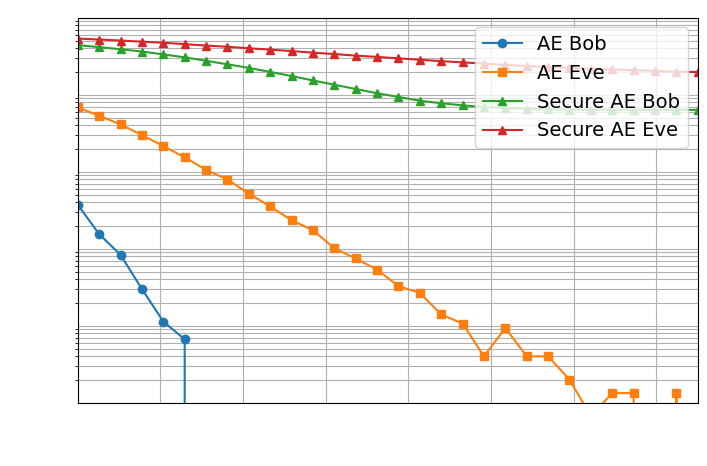

In [12]:
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data_bob[0], bber_data_bob[1], 'o-')                                                       # Plot different curves
plt.semilogy(bber_data_eve[0], bber_data_eve[1], 's-')
plt.semilogy(bber_sec_bob[0], bber_sec_bob[1], '^-')
plt.semilogy(bber_sec_eve[0], bber_sec_eve[1], '^-')
plt.gca().set_ylim(1e-5, 1)                                                                                  # Set y-axis limits and x-axis limits
plt.gca().set_xlim(0, 15)
plt.tick_params(axis='x', colors='white')                                                                    # Set tick colors
plt.tick_params(axis='y', colors='white')
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90, color='white')                               # Set labels and legend
plt.xlabel("SNR [dB]", fontsize=18, color='white')
plt.legend(['AE Bob', 'AE Eve', 'Secure AE Bob', 'Secure AE Eve'], prop={'size': 14}, loc='upper right')
plt.grid(True, which="both")                                                                                 # Add grid